In [16]:
from copy import deepcopy
import networkx as nx
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
import time

# Affinity Clustering

In [17]:
def path(filename):
    return f"C:/datasets/{filename}"

def extract_edge(line):
    """
    :param line: input in string
    :return: vertex v1, (vertex v2, weight of e(v1, v2))
    """
    splitted = line.split(' ')
    return int(splitted[0]), (int(splitted[1]), float(splitted[2]))  # <u, <v, e(u, v)>>


def create_adjacency_list(e):
    return e.groupByKey().mapValues(set)  

def closest_neighbor(adj_rdd):
    """
    Algorithm3
    """
    return adj_rdd.mapValues(lambda neighbors: min(neighbors, key=lambda a: a[1])[0])  # .sortByKey() <x, λ(x)>

def contract_from_vertex(start, lambda_rdd):
    """
    Algorithm 4, Map step
    """
    v = start
    c = start
    visited = set([])
    while v not in visited:
        visited.add(v)
        c = v
        v = lambda_rdd.get(v)  # v <- λ(v)
    label = min(c, v)
    return label, start

def contract_graph(adj_rdd, lambda_rdd, sc):
    """
    Algorithm 4, Reduce Step output adjacency list of contracted graph G'
    """
    lambda_bc = sc.broadcast(lambda_rdd)  # broadcast the value to all partitions
    temp_rdd = adj_rdd.map(lambda u: (contract_from_vertex(u[0], lambda_bc.value), u[1])) #<<label, start>, Neighbors<start>>

    # label_map O(n), information mapping each node to its label shared with all partitions
    label_map = temp_rdd.map(lambda x: (x[0][1], x[0][0])).collectAsMap()  # <start, label>
    label_map_bc = sc.broadcast(label_map)

    # Union neighbors to each label
    union_rdd = temp_rdd.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda x, y: x.union(y))  # <label, Neighbors(label)>

    def f(x): return x
    # Map each neighbor to its label and delete members with the current component's label
    filtered_rdd = union_rdd.flatMapValues(f).mapValues(lambda x: (label_map_bc.value.get(x[0]), x[1])).filter(
        lambda x: x[1][0] != x[0])

    # If multiple edges exist from the connected component to the same node, pick the one with minimum weight
    min_rdd = filtered_rdd.map(lambda x: ((x[0], x[1][0]), x[1][1])).reduceByKey(lambda x, y: min(x, y))

    out_rdd = min_rdd.map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(set)
    # repack the tuples <label, <neighbor, weight>>

    return out_rdd, label_map


def affinity(adj_rdd, sc):
    result = {}  # storing the V -> label for each level of clustering
    i = 0
    while True:
        print("round" + str(i))
        lambda_map = closest_neighbor(adj_rdd).collectAsMap()
        # result[i] = lambda_map
        adj_rdd, label_map = contract_graph(adj_rdd, lambda_map, sc)
        if adj_rdd.isEmpty():  # no more edges exist between vertices/clusters, single cluster formed
            break
        result[i] = label_map
        #print("label_map" + str(label_map))
        i += 1
    return result


def apply_affinity(edge_list):
    """
    :param edge_list: input to affinity clustering in the form [<u, v, w(u, v)>]
    Graph is
    :return: for each label of the clustering hierarchy a label vector of length #vertices
    in the form of a dictionary
    """
    conf = SparkConf().set("spark.executor.instances", "1").set("spark.executor.cores", "5")
      # 4 executor per instance of each worker  
      # 5 cores on each executor  
    
    sc = SparkContext(conf = conf)
    print(sc._conf.getAll())
    start = time.time()
    edges = sc.parallelize(edge_list, 5).map(lambda x: (int(x[0]), (int(x[1]), float(x[2]))))
    adj_rdd = create_adjacency_list(edges)
    result = affinity(adj_rdd, sc)
    labels = [i for i in range(len(result[0]))]
    leveled_label = {}
    count = 0
    while count < len(result):
        lmap = result[count]
        labels = deepcopy(labels)
        for i in range(len(labels)):
            labels[i] = lmap[labels[i]]
        leveled_label[count] = labels
        count += 1
    end = time.time()
    print(f"time took{end - start}")
    sc.stop()
    return leveled_label

#  Data Preprocessing

In [18]:
class nxGraph:
    G = nx.Graph()
    marked_nodes = []

    def __init__(self, edge_list):
        for edge in edge_list:
            self.G.add_edge(str(edge[0]), str(edge[1]), weight=edge[2])

    def mark_nodes(self, marked):
        self.marked_nodes.append(marked)
        return

    def plot(self):
        pos = nx.spring_layout(self.G, seed=7)
        # nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=100)

        # for group in self.marked_nodes:
        #    nx.draw_networkx_nodes(G, pos, nodelist=group, node_color=, node_size=700)
        # edges
        nx.draw_networkx_edges(self.G, pos, width=3)
        # labels
        nx.draw_networkx_labels(self.G, pos, font_size=10, font_family="sans-serif")
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, font_size=5, edge_labels=labels)

        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        return

    def is_connected(self):
        return nx.is_connected(self.G)


def path(filename):
    return f"C:/datasets/{filename}"


def parse_edges_from_file(file_name):
    edge_list = []
    with open(file_name) as f:
        lines = f.readlines()
    for line in lines:
        edge_list.append(line.split(" "))
    f.close()
    return edge_list


def generate_graph_with_cliques(n=5, inner_weight=5, outer_weight=10):
    edge_list = []
    count = n
    for i in range(1, n):
        edge_list.append(tuple([i, i + 1, outer_weight]))
    edge_list.append(tuple([n, 1, outer_weight]))
    for i in range(1, n + 1):
        clique_list = [x for x in range(count + 1, count + i + 1)]
        clique_list.append(i)
        for m in clique_list:
            for n in clique_list:
                if m != n:
                    edge_list.append(tuple([m, n, inner_weight]))
        count += i
    return edge_list


def save_edge_list_to_file(edge_list, file_path):
    file = open(file_path, "w")
    for edge in edge_list:
        file.write(" ".join([str(i) for i in edge]))
        file.write("\n")
    file.close()
    return

# Applying Affinity and Plotting  

In [19]:
from sklearn import datasets, metrics
import numpy as np
from itertools import islice, cycle
import matplotlib.pyplot as plt
# from seaborn import heatmap

plt.rcParams["figure.figsize"] = (20,20)

def pairwise_euclidean_distance(coord_list):
    return metrics.pairwise_distances(coord_list, metric='euclidean')


def distance_matrix_to_edge_list(matrix):
    edge_list = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if j != i:          # exclude self edges
                edge_list.append(tuple([i, j, matrix[i][j]]))
    return edge_list


def process_dataset(dataset):
    dist_matrix = pairwise_euclidean_distance(dataset[0])
    #dist_matrix = filter_long_edge(dist_matrix, 10)
    # print(dist_matrix)
    return distance_matrix_to_edge_list(dist_matrix)


def filter_long_edge(edge_list, threshold=15):
    filtered = []
    for edge in edge_list:
        if edge[2] <= threshold:
            filtered.append(edge)
    filtered_graph = nxGraph(filtered)
    if not filtered_graph.is_connected():
        print("Filtered graph not connected. Cannot perform affinity clustering! Increase the threshold.")
        return
    print(len(filtered))
    return filtered


def plot_cluster_per_layer(dataset):
    colors = np.array(list(islice(cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']), len(dataset[0]))))
    # adjust plot size
    plt.figure(figsize=(9 * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                         hspace=.01)
    result = apply_affinity(process_dataset(dataset))
    #print(result)
    #print(reverse_label_map_layered)
    num_levels = len(result.keys())
    plot_num = 1
    for i in range(num_levels):
        labels = result[i]
        plt.subplot(num_levels, num_levels, plot_num)
        plt.scatter(dataset[0][:, 0], dataset[0][:, 1], s=10, color=colors[labels])
        plot_num += 1
    plt.show()
    return


def plot_labels(dataset):
    colors = np.array(list(islice(cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']), len(dataset[0]))))
    plt.scatter(dataset[0][:, 0], dataset[0][:, 1], 10, color=colors[dataset[1]])
    return 

def plot_comparison(dataset):
    plt.subplot(2, 2, 1)
    plot_labels(dataset)
    plt.subplot(2, 2, 2)
    result, reverse_label_map_layered = apply_affinity(process_dataset(dataset))
    labels = result[len(result.keys()) - 1]
    colors = np.array(list(islice(cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']), len(dataset[0]))))
    plt.scatter(dataset[0][:, 0], dataset[0][:, 1], s=10, color=colors[labels])
    return 

# Beginning of Experiments

In [20]:
n_samples = 5000

import random

def random_points_within(num_points, bounds):
    min_x, min_y, max_x, max_y = bounds

    points = []

    while len(points) < num_points:
        random_point = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        points.append(random_point)
    return points


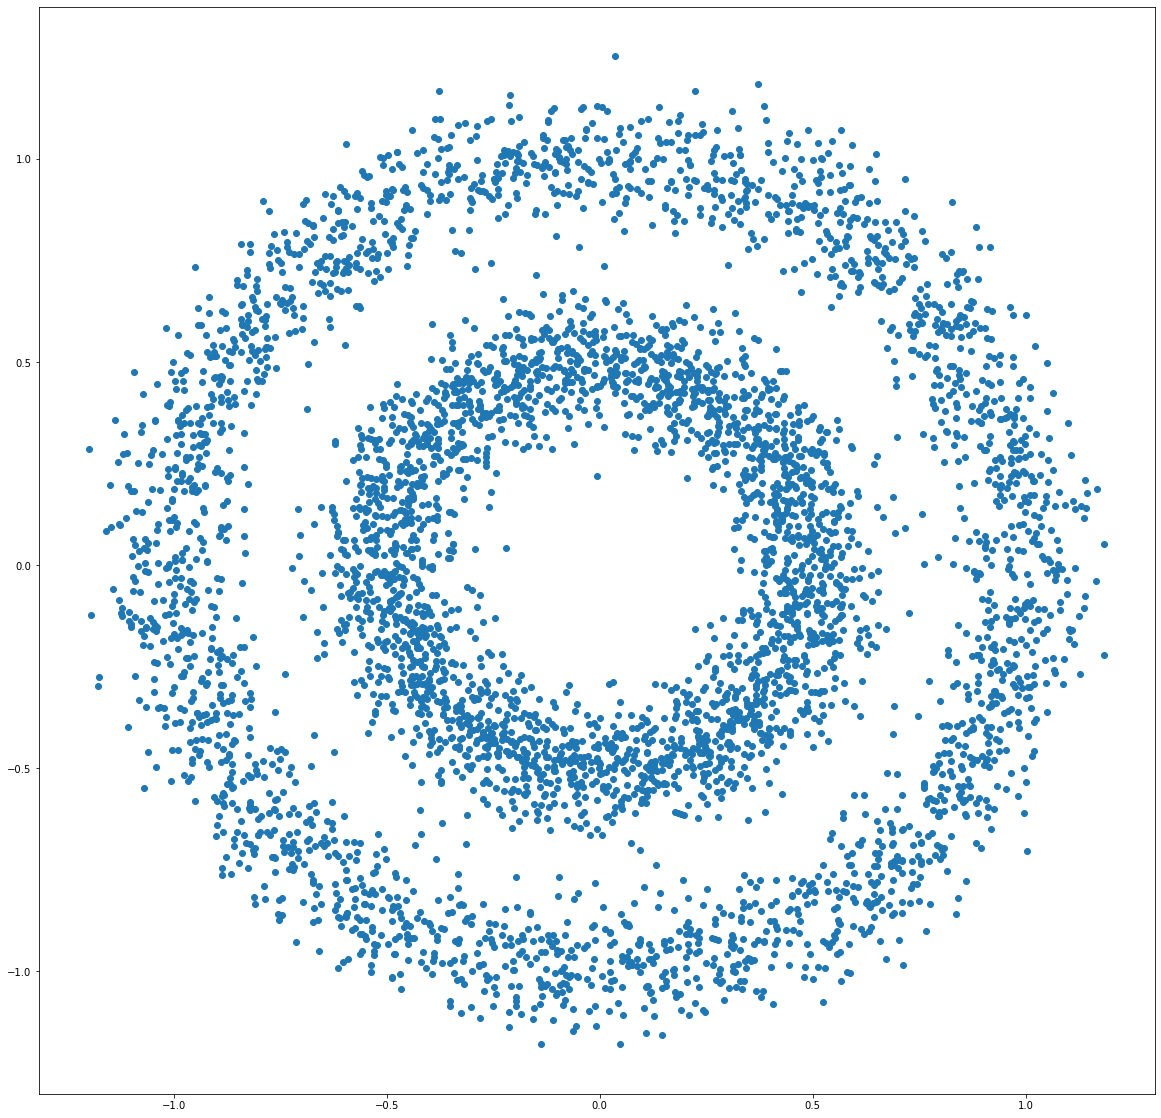

In [21]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.08)
noisy_circles_dataset = noisy_circles[0]
#noise_size = 20
#step_size = 2/noise_size
#x_coord = []
#y = 0
##x = -1
#for i in range(noise_size):
#    x += step_size 
#    x_coord.append([x, y])
num_points = 60

bounds = [-1.1, -0.05, 1.1, 0.05]

    
#noisy_circles_dataset = np.append(noisy_circles_dataset, random_points_within(num_points, bounds), axis = 0)

noisy_circles = noisy_circles_dataset, noisy_circles[1]

fig = plt.plot(noisy_circles_dataset[:, 0], noisy_circles_dataset[:, 1], "o")


[('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.driver.port', '56262'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1639459003443'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
round1
round2
round3
round4
time took77.93646740913391


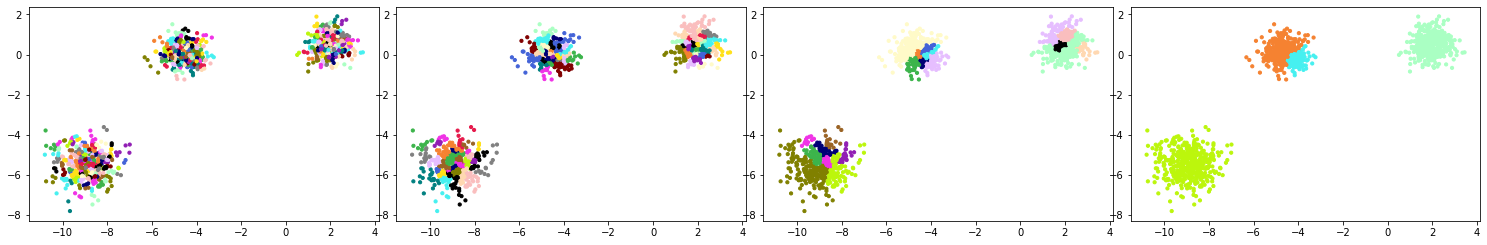

In [22]:
# blobs with varied variances
n_samples = 1250
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

[('spark.app.id', 'local-1639458413562'), ('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.driver.port', '55302'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
label_map{0: 0, 5: 1598, 10: 852, 15: 15, 20: 20, 25: 25, 30: 1160, 35: 1319, 40: 40, 45: 789, 50: 50, 55: 55, 60: 60, 65: 65, 70: 787, 75: 75, 80: 80, 85: 85, 90: 90, 95: 58, 100: 18, 105: 2154, 110: 110, 115: 115, 120: 120, 125: 125, 130: 130, 135: 135, 140: 1077, 145: 227, 150: 150, 155: 357, 160: 160, 165: 1163, 170: 2, 175: 2378, 180: 735, 185: 185, 190: 190, 195: 195, 200: 200, 205: 971, 210: 210, 215: 845, 220: 220, 225: 225, 230: 787, 235: 26, 240: 34, 245: 245, 250: 250, 255: 1103, 260: 260, 265: 265, 270: 

label_map{0: 533, 15: 500, 20: 20, 25: 25, 1160: 237, 40: 40, 50: 2, 55: 331, 60: 520, 65: 246, 75: 75, 80: 693, 85: 309, 90: 90, 110: 110, 115: 115, 120: 120, 125: 97, 130: 533, 135: 81, 150: 150, 160: 160, 735: 34, 185: 185, 190: 190, 195: 34, 200: 749, 210: 210, 845: 845, 220: 1153, 225: 280, 245: 245, 250: 742, 260: 260, 265: 945, 270: 610, 275: 275, 280: 280, 310: 310, 320: 320, 325: 157, 335: 1203, 340: 254, 345: 345, 350: 381, 360: 237, 365: 365, 370: 365, 375: 90, 405: 405, 410: 18, 425: 425, 435: 193, 445: 1276, 450: 151, 470: 157, 485: 162, 490: 490, 495: 495, 500: 500, 505: 906, 510: 1823, 520: 520, 525: 278, 2200: 177, 550: 1462, 560: 560, 565: 246, 575: 736, 585: 585, 605: 122, 610: 610, 615: 615, 620: 490, 630: 614, 635: 635, 645: 150, 650: 709, 655: 655, 670: 670, 695: 588, 710: 275, 715: 292, 720: 1276, 725: 309, 740: 13, 745: 192, 750: 141, 2120: 1447, 785: 785, 795: 371, 800: 809, 815: 90, 825: 825, 830: 469, 835: 282, 840: 840, 850: 459, 855: 500, 865: 749, 870: 37, 

label_map{500: 97, 20: 91, 25: 25, 40: 40, 520: 585, 75: 11, 90: 615, 110: 110, 115: 494, 120: 120, 150: 150, 160: 247, 185: 185, 190: 190, 210: 588, 845: 599, 280: 53, 245: 310, 260: 193, 945: 383, 610: 776, 275: 599, 310: 310, 320: 320, 345: 273, 365: 31, 405: 139, 425: 1264, 490: 157, 495: 9, 560: 154, 585: 585, 615: 615, 635: 206, 655: 655, 670: 867, 785: 71, 825: 107, 840: 655, 1030: 383, 1060: 615, 1200: 208, 331: 331, 246: 154, 81: 81, 381: 37, 1276: 983, 151: 157, 906: 9, 736: 310, 141: 82, 371: 154, 256: 776, 206: 206, 636: 588, 1061: 87, 501: 648, 286: 139, 451: 206, 71: 71, 1301: 11, 1926: 107, 986: 237, 421: 31, 1401: 320, 921: 44, 91: 91, 656: 524, 276: 588, 786: 363, 186: 193, 11: 11, 31: 31, 51: 310, 131: 412, 111: 190, 211: 83, 291: 9, 296: 190, 511: 331, 536: 536, 776: 776, 1116: 11, 1296: 11, 1831: 776, 237: 237, 2: 615, 97: 97, 742: 139, 157: 157, 162: 9, 177: 247, 1462: 585, 122: 349, 292: 84, 192: 206, 1447: 648, 282: 28, 37: 37, 1752: 358, 602: 11, 672: 53, 547: 5

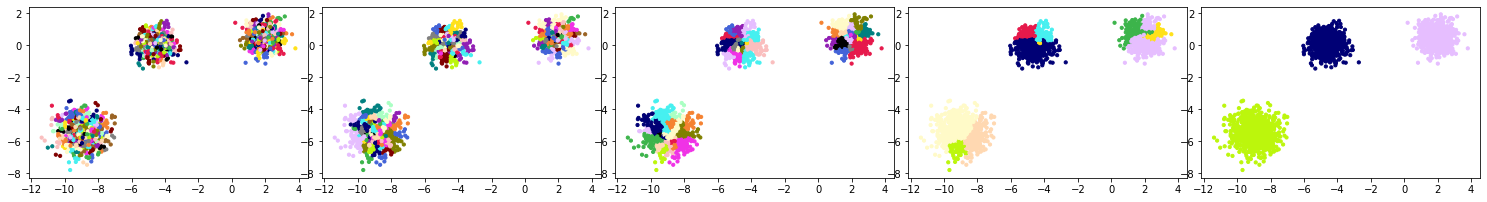

In [12]:
# blobs with varied variances
n_samples = 2750
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std= [0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

[('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.port', '60802'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell'), ('spark.app.id', 'local-1639416860940')]
round0
label_map{0: 0, 5: 5, 10: 27, 15: 262, 20: 74, 25: 45, 30: 30, 35: 40, 40: 40, 45: 45, 50: 36, 55: 19, 60: 1, 65: 65, 70: 4, 75: 36, 80: 107, 85: 11, 90: 42, 95: 212, 100: 5, 105: 105, 110: 110, 115: 101, 120: 65, 125: 39, 130: 130, 135: 44, 140: 107, 145: 5, 150: 150, 155: 197, 160: 127, 165: 62, 170: 169, 175: 107, 180: 105, 185: 185, 190: 152, 195: 172, 200: 23, 205: 261, 210: 210, 215: 4, 220: 0, 225: 198, 230: 197, 235: 63, 240: 72, 245: 67, 250: 81, 255: 185, 260: 254, 265: 176, 270: 212, 275: 127, 280: 179, 2

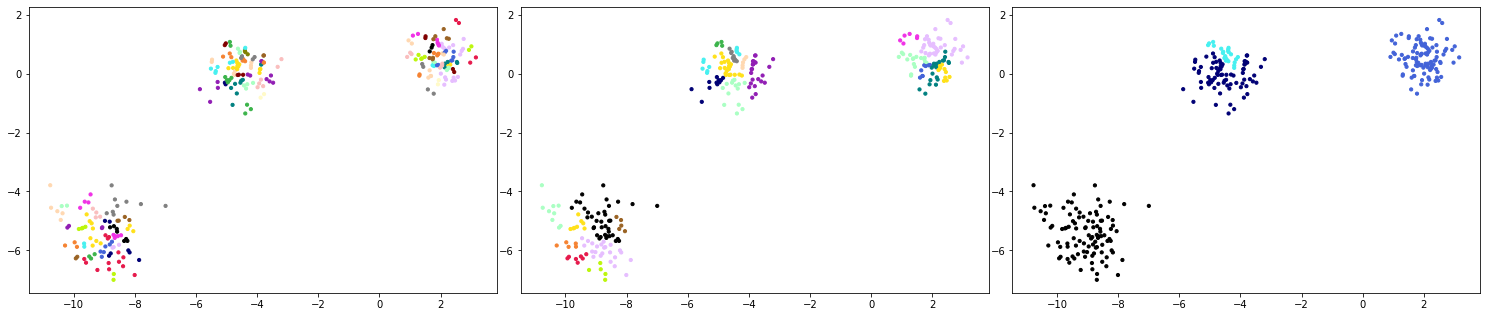

In [9]:
# blobs with varied variances
n_samples = 300
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

[('spark.app.id', 'local-1639416927266'), ('spark.driver.port', '61179'), ('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
label_map{0: 17, 5: 187, 10: 10, 15: 170, 20: 249, 25: 17, 30: 86, 35: 140, 40: 40, 45: 45, 50: 427, 55: 217, 60: 60, 65: 65, 70: 70, 75: 75, 80: 516, 85: 85, 90: 34, 95: 460, 100: 42, 105: 105, 110: 110, 115: 56, 120: 120, 125: 125, 130: 130, 135: 135, 140: 140, 145: 278, 150: 150, 155: 155, 160: 56, 165: 165, 170: 170, 175: 175, 180: 46, 185: 185, 190: 190, 195: 472, 200: 96, 205: 205, 210: 210, 215: 215, 220: 220, 225: 225, 230: 514, 235: 510, 240: 319, 245: 245, 250: 73, 255: 146, 260: 260, 265: 265, 270: 270, 2

label_map{140: 14, 40: 40, 45: 45, 60: 46, 75: 63, 85: 46, 185: 18, 120: 14, 125: 63, 490: 38, 155: 14, 220: 38, 205: 40, 215: 188, 225: 14, 46: 46, 206: 38, 111: 269, 246: 246, 276: 246, 71: 63, 101: 45, 191: 14, 97: 46, 102: 188, 42: 42, 262: 59, 342: 38, 122: 14, 202: 46, 22: 49, 222: 134, 7: 134, 72: 188, 267: 267, 182: 49, 197: 49, 68: 38, 28: 46, 188: 188, 18: 18, 353: 269, 433: 49, 63: 63, 38: 38, 138: 14, 228: 269, 69: 63, 74: 46, 29: 14, 134: 134, 49: 49, 59: 59, 319: 46, 39: 46, 344: 267, 269: 269, 94: 42, 14: 14, 129: 14, 139: 14}
round3
label_map{40: 14, 45: 46, 46: 46, 246: 46, 42: 18, 267: 46, 63: 18, 18: 18, 188: 18, 38: 14, 14: 14, 269: 46, 59: 18, 49: 18, 134: 46}
round4
time took78.41629195213318
{0: [17, 208, 181, 3, 4, 187, 6, 7, 65, 9, 10, 11, 343, 305, 14, 170, 16, 17, 18, 19, 249, 297, 22, 135, 206, 17, 26, 306, 28, 29, 86, 91, 40, 509, 34, 140, 36, 9, 38, 39, 40, 41, 42, 104, 427, 45, 46, 460, 182, 49, 427, 210, 52, 38, 343, 217, 56, 86, 41, 59, 60, 140, 62, 63,

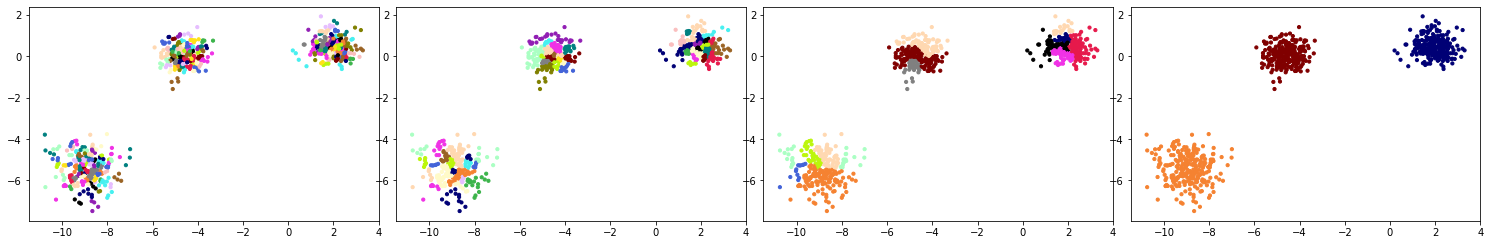

In [10]:
# blobs with varied variances
n_samples = 750
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

[('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.driver.port', '56687'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1639459299916'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
round1
round2
round3
round4
round5
time took90.67683029174805


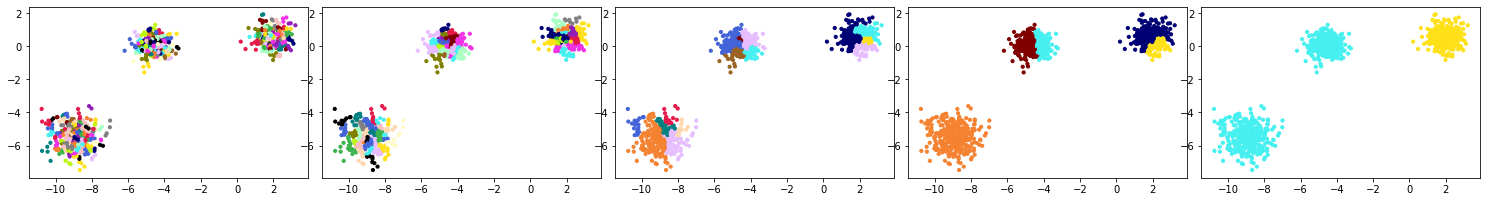

In [24]:
# blobs with varied variances
n_samples =  1000
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

In [1]:
sc.stop()

NameError: name 'sc' is not defined

In [ ]:
# blobs with varied variances
n_samples = 4500
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)

print("done filtering")
plot_cluster_per_layer(varied)

done filtering
[('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.app.id', 'local-1639423322212'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.driver.port', '58219'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0


[('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.driver.port', '53858'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1639457514888'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
label_map{0: 0, 5: 5, 10: 10, 15: 15, 20: 20, 25: 1009, 30: 30, 35: 316, 40: 40, 45: 1139, 50: 50, 55: 960, 60: 60, 65: 65, 70: 70, 75: 75, 80: 80, 85: 97, 90: 837, 95: 95, 100: 1051, 105: 105, 110: 110, 115: 88, 120: 120, 125: 125, 130: 130, 135: 2, 140: 140, 145: 145, 150: 2, 155: 894, 160: 871, 165: 724, 170: 170, 175: 175, 180: 492, 185: 204, 190: 190, 195: 1221, 200: 237, 205: 205, 210: 210, 215: 1164, 220: 220, 225: 312, 230: 230, 235: 1231, 240: 506, 245: 777, 250: 250, 255: 535, 260: 34, 265: 613, 270: 270, 

label_map{0: 0, 5: 5, 10: 172, 15: 202, 20: 20, 30: 30, 40: 932, 50: 334, 960: 403, 60: 74, 65: 65, 70: 88, 75: 75, 80: 80, 95: 263, 105: 282, 110: 110, 120: 120, 125: 125, 130: 130, 140: 793, 145: 145, 170: 9, 175: 21, 190: 190, 205: 326, 210: 161, 220: 220, 230: 111, 250: 403, 535: 1262, 270: 1187, 290: 395, 300: 300, 305: 283, 310: 861, 315: 861, 330: 330, 345: 5, 355: 440, 365: 11, 370: 125, 375: 120, 395: 395, 400: 103, 405: 128, 410: 410, 420: 257, 440: 440, 460: 63, 465: 114, 470: 470, 480: 166, 510: 453, 495: 110, 500: 324, 515: 149, 545: 545, 560: 453, 570: 186, 575: 541, 580: 514, 595: 326, 600: 43, 610: 21, 620: 309, 625: 79, 635: 7, 660: 183, 670: 388, 1355: 898, 720: 103, 1025: 282, 740: 130, 1620: 1369, 775: 88, 790: 790, 805: 805, 820: 820, 825: 820, 835: 172, 840: 388, 865: 727, 880: 74, 895: 75, 925: 453, 935: 11, 970: 28, 980: 172, 985: 57, 990: 990, 995: 990, 1020: 805, 1075: 216, 1060: 107, 1085: 27, 1090: 470, 1100: 66, 1120: 861, 1125: 1125, 1160: 1051, 1220: 388,

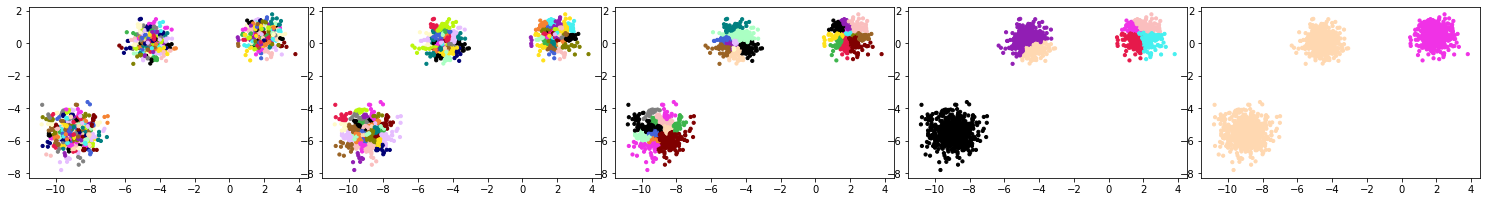

In [7]:
# blobs with varied variances
n_samples = 1750
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

[('spark.app.id', 'local-1639457617905'), ('spark.driver.host', 'LAPTOP-UQFONGLQ'), ('spark.rdd.compress', 'True'), ('spark.executor.cores', '5'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.driver.port', '54328'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell')]
round0
label_map{0: 815, 5: 5, 10: 10, 15: 15, 20: 596, 25: 1435, 30: 30, 35: 574, 40: 40, 45: 904, 50: 50, 55: 55, 60: 263, 65: 65, 70: 1658, 75: 75, 80: 80, 85: 85, 90: 90, 95: 95, 100: 508, 105: 1187, 110: 110, 115: 115, 120: 1902, 125: 125, 130: 130, 135: 135, 140: 140, 145: 1161, 150: 150, 155: 155, 160: 1369, 165: 1913, 170: 1502, 175: 175, 180: 180, 185: 185, 190: 8, 195: 43, 200: 200, 205: 205, 210: 210, 215: 1772, 220: 220, 225: 225, 230: 284, 235: 866, 240: 156, 245: 245, 250: 250, 255: 255, 260: 260, 265: 265, 2

label_map{815: 80, 5: 767, 10: 602, 15: 15, 1435: 88, 30: 30, 40: 40, 50: 50, 55: 984, 65: 255, 75: 75, 80: 80, 85: 85, 90: 90, 95: 95, 110: 110, 115: 191, 125: 285, 130: 1072, 135: 135, 140: 30, 150: 224, 155: 155, 175: 184, 180: 180, 185: 84, 200: 274, 205: 846, 210: 210, 220: 220, 225: 808, 245: 457, 250: 257, 255: 255, 260: 260, 265: 265, 285: 285, 290: 244, 295: 984, 300: 455, 305: 1150, 800: 345, 325: 263, 340: 233, 345: 345, 350: 350, 360: 258, 370: 88, 380: 263, 390: 390, 395: 395, 400: 163, 405: 405, 415: 405, 420: 420, 515: 24, 435: 107, 440: 440, 455: 455, 460: 283, 465: 465, 470: 562, 480: 480, 495: 1, 500: 1275, 525: 29, 530: 530, 535: 535, 560: 560, 565: 383, 770: 546, 595: 88, 610: 808, 615: 519, 1800: 917, 655: 655, 665: 665, 1280: 767, 685: 507, 695: 655, 715: 213, 730: 455, 750: 1388, 760: 80, 780: 780, 785: 37, 1475: 655, 795: 795, 805: 1072, 825: 377, 830: 13, 850: 202, 865: 19, 890: 12, 915: 808, 925: 359, 945: 655, 960: 535, 965: 463, 1010: 1072, 1020: 350, 1025: 

label_map{15: 15, 40: 74, 455: 62, 75: 75, 85: 74, 95: 74, 285: 88, 155: 88, 350: 74, 260: 75, 795: 88, 241: 62, 1: 74, 191: 191, 26: 15, 767: 74, 62: 62, 387: 191, 407: 191, 277: 88, 257: 75, 133: 74, 208: 74, 88: 88, 238: 88, 158: 75, 283: 74, 13: 191, 178: 74, 174: 74, 309: 15, 184: 191, 849: 75, 74: 74, 69: 88, 29: 74, 224: 88}
round4
label_map{15: 15, 75: 75, 191: 75, 62: 15, 88: 15, 74: 75}
round5
time took103.79779005050659
{0: [815, 1, 451, 3, 293, 5, 6, 872, 8, 98, 10, 1469, 12, 13, 14, 15, 16, 1272, 18, 19, 596, 21, 22, 23, 24, 1435, 26, 27, 383, 29, 30, 463, 32, 33, 1624, 574, 1400, 37, 1354, 39, 40, 41, 42, 43, 1341, 904, 768, 217, 222, 49, 50, 245, 52, 204, 54, 55, 56, 830, 1150, 1432, 263, 328, 62, 358, 64, 65, 66, 67, 1426, 69, 1658, 71, 804, 73, 74, 75, 76, 77, 78, 1370, 80, 1165, 82, 83, 84, 85, 115, 87, 88, 205, 90, 37, 380, 93, 94, 95, 312, 97, 98, 99, 508, 101, 435, 1053, 104, 1187, 106, 107, 108, 109, 110, 111, 112, 541, 114, 115, 116, 117, 769, 119, 1902, 121, 819

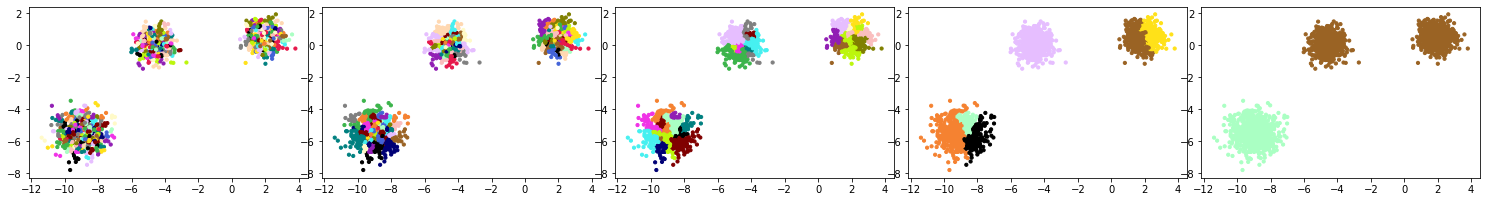

In [8]:
# blobs with varied variances
n_samples = 2250
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

In [ ]:
# blobs with varied variances
n_samples = 6000
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[0.7, 0.5, 0.5],
                             random_state=random_state)
plot_cluster_per_layer(varied)

In [ ]:
from sklearn import cluster
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X, y = noisy_circles
db = cluster.DBSCAN(eps=0.5).fit(X)
y_pred = db.labels_
print(y_pred)


colors = np.array(list(islice(cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']), int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

In [ ]:
#noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X, y = noisy_circles
optics = cluster.OPTICS(min_samples=20,
                            xi=0.05,
                            min_cluster_size=0.1).fit(X)
y_pred = optics.labels_
print(y_pred)


colors = np.array(list(islice(cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']), int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])



In [ ]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_circles_dataset = noisy_circles[0]
noise_size = 20
step_size = 2/noise_size
points = []
y = -0.4
x = -1
for i in range(noise_size):
    x += step_size 
    points.append([x, y])
y = 0
x = -1
for i in range(noise_size):
    x += step_size 
    points.append([x, y])
y = 0.4
x = -1
for i in range(noise_size):
    x += step_size 
    points.append([x, y])
noisy_circles_dataset = np.append(noisy_circles_dataset, points, axis = 0)
noisy_circles = noisy_circles_dataset, noisy_circles[1]

fig = plt.plot(noisy_circles_dataset[:, 0], noisy_circles_dataset[:, 1], "o")
#circles_with_unit_noise_40

In [ ]:
plot_cluster_per_layer(noisy_circles)

In [ ]:
arr = {0: {16: 4, 48: 3, 80: 4, 96: 3, 144: 5, 160: 3, 192: 2, 240: 2, 256: 9, 272: 2, 320: 3, 336: 5, 416: 6, 384: 3, 496: 4, 209: 3, 241: 2, 385: 3, 1: 2, 33: 2, 49: 2, 65: 3, 81: 3, 97: 3, 113: 2, 353: 5, 161: 3, 193: 3, 225: 3, 257: 9, 305: 2, 401: 4, 433: 4, 465: 3, 545: 2, 226: 5, 130: 6, 162: 4, 114: 4, 210: 3, 146: 4, 34: 4, 178: 3, 242: 4, 274: 4, 290: 4, 354: 3, 386: 3, 579: 4, 227: 2, 259: 3, 419: 7, 675: 5, 211: 3, 83: 4, 339: 6, 3: 2, 51: 3, 99: 5, 147: 2, 179: 2, 388: 3, 724: 4, 660: 3, 548: 3, 228: 2, 324: 3, 4: 5, 36: 3, 68: 3, 84: 3, 116: 3, 148: 3, 164: 2, 180: 2, 212: 4, 276: 4, 356: 4, 420: 3, 596: 2, 165: 5, 69: 7, 117: 4, 357: 4, 277: 3, 37: 4, 485: 4, 5: 2, 21: 2, 53: 2, 101: 2, 149: 2, 181: 3, 197: 2, 213: 3, 373: 3, 517: 2, 230: 3, 86: 3, 182: 4, 262: 3, 454: 2, 646: 3, 198: 2, 6: 3, 22: 2, 54: 2, 406: 3, 134: 2, 166: 2, 246: 3, 294: 2, 374: 2, 598: 2, 662: 3, 87: 4, 55: 4, 151: 4, 103: 3, 39: 4, 7: 3, 23: 2, 71: 6, 167: 6, 183: 2, 231: 2, 295: 4, 311: 3, 359: 3, 663: 2, 264: 5, 488: 3, 8: 3, 40: 7, 72: 3, 120: 4, 248: 3, 552: 4, 24: 3, 216: 2, 168: 2, 136: 3, 89: 2, 377: 4, 201: 6, 41: 5, 265: 5, 169: 3, 281: 6, 393: 4, 249: 3, 233: 3, 73: 4, 457: 3, 121: 2, 25: 2, 57: 3, 217: 3, 522: 4, 90: 3, 122: 5, 490: 4, 282: 3, 314: 4, 10: 3, 58: 2, 298: 2, 346: 2, 43: 5, 187: 5, 731: 5, 75: 7, 123: 3, 107: 2, 315: 3, 251: 2, 763: 3, 475: 2, 379: 2, 11: 2, 91: 3, 139: 2, 347: 2, 427: 2, 140: 2, 124: 6, 12: 5, 476: 4, 636: 2, 60: 2, 348: 3, 284: 2, 460: 4, 540: 2, 300: 2, 492: 3, 396: 3, 444: 4, 588: 2, 316: 2, 349: 2, 445: 3, 237: 4, 253: 4, 45: 4, 269: 3, 541: 2, 61: 4, 109: 3, 653: 3, 317: 3, 125: 2, 141: 5, 189: 2, 381: 2, 77: 3, 78: 5, 686: 3, 590: 4, 350: 7, 638: 3, 222: 5, 606: 4, 542: 5, 382: 3, 206: 3, 62: 4, 126: 2, 334: 3, 254: 2, 47: 3, 191: 2, 175: 3, 287: 2, 127: 3, 319: 2, 367: 2, 783: 5, 543: 3, 671: 2, 559: 2, 351: 2, 143: 2, 383: 2, 31: 2}, 1: {16: 4, 256: 5, 336: 3, 209: 8, 49: 5, 65: 6, 81: 4, 162: 3, 114: 3, 51: 2, 147: 5, 179: 2, 84: 5, 116: 5, 228: 3, 68: 2, 373: 5, 213: 4, 21: 7, 165: 2, 101: 2, 182: 5, 246: 3, 22: 2, 86: 4, 262: 3, 71: 2, 7: 8, 151: 4, 55: 2, 103: 4, 87: 4, 183: 2, 72: 3, 8: 4, 40: 3, 24: 3, 57: 4, 377: 2, 25: 2, 90: 3, 10: 4, 298: 2, 522: 3, 123: 4, 139: 3, 427: 4, 43: 2, 11: 2, 12: 4, 140: 6, 540: 3, 348: 4, 124: 3, 300: 2, 349: 5, 77: 2, 381: 4, 189: 5, 109: 2, 317: 5, 62: 3, 78: 5, 222: 3, 31: 2, 383: 4, 175: 2, 127: 3, 47: 2}, 2: {49: 3, 81: 2, 162: 2, 147: 2, 84: 3, 165: 2, 101: 4, 22: 5, 182: 2, 87: 4, 151: 4, 72: 3, 40: 3, 24: 2, 25: 3, 57: 3, 10: 2, 139: 3, 140: 2, 77: 5, 189: 2, 62: 2, 127: 3, 31: 3}, 3: {49: 3, 81: 3, 22: 4, 72: 3, 24: 2, 140: 3, 77: 2, 62: 4}, 4: {24: 5, 62: 3}}
out_arr = convert_rev_label_map_to_np(arr, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

 # Noisy Moons

In [ ]:
n_samples=400
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.07)
noisy_moons_dataset = noisy_moons[0]
noise_size = 20
step_size = 3/noise_size
points = []
y = 0.25
x = -1
for i in range(noise_size):
    x += step_size 
    points.append([x, y])

noisy_moons_dataset = np.append(noisy_moons_dataset, points, axis = 0)
noisy_moons = noisy_moons_dataset, noisy_moons[1]

fig = plt.plot(noisy_moons_dataset[:, 0], noisy_moons_dataset[:, 1], "o")


In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(noisy_moons)

In [ ]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
plot_cluster_per_layer(noisy_moons)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
n_samples = 3000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
reverse_label_map_layered = plot_cluster_per_layer(noisy_moons)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

  # Blobs with varied variances

In [ ]:
# blobs with varied variances
n_samples = 3000
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
reverse_label_map_layered = plot_cluster_per_layer(varied)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
# blobs with varied variances
n_samples = 5000
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
reverse_label_map_layered = plot_cluster_per_layer(varied)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
# blobs with varied variances
n_samples = 800
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
reverse_label_map_layered = plot_cluster_per_layer(varied)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

 # Anistropicly distributed

In [ ]:
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
reverse_label_map_layered = plot_cluster_per_layer(aniso)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
reverse_label_map_layered = plot_cluster_per_layer(aniso)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

# Three Blobs randomstate 8 

In [ ]:
n_samples = 1500
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# print(blobs)
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
reverse_label_map_layered = plot_cluster_per_layer(varied)

# 3D swissroll dataset 800

In [ ]:
from sklearn.datasets import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3

n_samples = 800
noise = 0.05
X, y = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5
swiss_roll = X, y
print(X)

result, reverse_label_map_layered = apply_affinity(process_dataset(swiss_roll))

labels = result[max(result.keys())]
print(labels)


In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(labels):
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels, cmap = plt.cm.Set1,
               s = 40, edgecolor='k')

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

# 3D swissroll dataset 1500

In [ ]:
from sklearn.datasets import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3

n_samples = 1500
noise = 0.05
X, y = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= .5
swiss_roll = X, y
print(X)

result, reverse_label_map_layered = apply_affinity(process_dataset(swiss_roll))

labels = result[max(result.keys())]
print(labels)

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(labels):
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels, cmap = plt.cm.Set1,
               s = 40, edgecolor='k')

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

 # Iris dataset Original labels 

In [ ]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
from sklearn.decomposition import PCA

iris = datasets.load_iris()
y = iris.target

fig = plt.figure()
ax = p3.Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=60)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

print(y)

plt.show()

In [ ]:
iris = X_reduced, y
result, reverse_label_map_layered = apply_affinity(process_dataset(iris))

labels = result[max(result.keys())]
print(labels)

# Iris Affinity clustering labels

In [ ]:
fig = plt.figure()
ax = p3.Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

 # Three blobs, two small one big - 1500

In [ ]:
n_samples = 1500

random_state = 170
varied = datasets.make_blobs(n_samples=n_samples, centers = [(3, 2), (3, 4), (4, 3)], cluster_std=[0.1, 0.1, 0.5],)
        
#plt.scatter(varied[0][:, 0], varied[0][:, 1], s=10)
        
reverse_label_map_layered = plot_cluster_per_layer(varied)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

 # Three blobs, two big one small - 1500

In [ ]:
random_state = 170
varied = datasets.make_blobs(n_samples=n_samples, centers = [(3, 2), (3, 4), (4, 3)], cluster_std=[0.4, 0.4, 0.1],)
        
#plt.scatter(varied[0][:, 0], varied[0][:, 1], s=10)
        
reverse_label_map_layered = plot_cluster_per_layer(varied)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
no_structure = np.random.rand(n_samples, 2), None

reverse_label_map_layered = plot_cluster_per_layer(no_structure)

In [ ]:
out_arr = convert_rev_label_map_to_np(reverse_label_map_layered, n_samples)
heatmap(out_arr, cmap="BuPu")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
plt.rcParams["figure.figsize"] = (8, 8)
import random 

def calculate_separation(std, dimension, exponent):
    return std *(dimension**exponent)


def gauss_2d(mu1, mu2, sigma, sigma2= None):
    x = random.gauss(mu1, sigma)
    sigma2 = sigma if not sigma2 else sigma2
    y = random.gauss(mu2, sigma2)
    return [x, y]

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.1
n_samples = 100000
random_state = 1234
y_1 = 1
std = 0.1
dimension = 2
exponent = 0.5
separation =  0.5 * calculate_separation(std, dimension, exponent)


blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#DS00, Bounded Eccentricity, Experiment 1, Std = 0.1
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.1
dimension = 2 
exponent = 0.25
separation = calculate_separation(std, dimension, exponent)
print(separation)
#separation = 2
blobs = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])
blobs = blobs[0]

xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 1/2
separation = calculate_separation(std, dimension, exponent)

blobs = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])
blobs = blobs[0]

xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)

In [ ]:
#DS00, Bounded Eccentricity, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2 
dimension = 2 
exponent = 1/4
separation = calculate_separation(std, dimension, exponent)
blobs = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])
blobs = blobs[0]

xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)

In [ ]:
#Product Distribution, Expriment 1, Std = 0.2 
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2 
num_clusters = 2 
exponent = 1/4
separation = calculate_separation(std, num_clusters, exponent)
blobs = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])
blobs = blobs[0]

xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2, with self-implemented code
n_samples = 100000
random_state = 1234


std = 0.2
dimension = 2
exponent = 0.5
separation = 4 * calculate_separation(std, dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, 0.2))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, 0.2))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 100000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation = 4 *calculate_separation(std, dimension, exponent)
print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#Das99, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
epsilon = std_x/std_y
dimension = 2
exponent = 0.5
separation = 1*calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#DS00, Bounded Eccentricity, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 100000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.25
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#Das99, Spherical Gaussian, Experiment 3, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 100000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.5
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + 2 * separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#DS00, Bounded Eccentricity, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 100000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.25
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + 2*separation, std_x, std_y))
blobs = np.array(blobs)

#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#VW02, Spherical Gaussians , Experiment 3, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 100000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 3
exponent = 0.25
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + 2 * separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#Das99, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 100000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.5
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.5
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Bounded Eccentricity, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 700


std_x = 0.4
std_y = 0.1
dimension = 2
exponent = 0.25
separation = calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation =  calculate_separation(std, dimension, exponent)
#print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation = 2 *calculate_separation(std, dimension, exponent)
#print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)
blobs = blobs, 0


In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation = 1 *calculate_separation(std, dimension, exponent)
#print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation = 0.5 *calculate_separation(std, dimension, exponent)
#print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#Das99, Spherical Gaussian, Experiment 1, Std = 0.2
n_samples = 1000
random_state = 1234
y_1 = 1
std = 0.2
dimension = 2
exponent = 0.5
separation = 4 *calculate_separation(std, dimension, exponent)
#print(separation)

blobs, y = datasets.make_blobs(n_samples=n_samples, centers = [(0, y_1), (0, y_1 + separation)], cluster_std = [std, std])


for i in range(2):
     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-2, 2)
ymin, ymax = plt.ylim(0, 4)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.5)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 0.5 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 1 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 2 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 4 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
reverse_label_map_layered = plot_cluster_per_layer(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 4 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []

labels = []

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    labels.append(0)
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
    labels.append(1)
blobs = np.array(blobs)
labels = np.array(labels)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

#fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, labels
plot_labels(blobs)


In [ ]:
plot_comparison(blobs)

In [ ]:
#DS00, Spherical Gaussian, Experiment 2, std_x = 0.4, std = 0.1, with self-implemented Gaussian
n_samples = 1000
random_state = 1234


std_x = 0.2
std_y = 0.1
dimension = 2
exponent = 0.5
separation = 1 * calculate_separation(max(std_x, std_y), dimension, exponent)
print(separation)

blobs = []
for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1, std_x, std_y))
    
print(np.std(blobs, axis = 0))

for i in range(n_samples): 
    blobs.append(gauss_2d(0, 1 + separation, std_x, std_y))
blobs = np.array(blobs)


#for i in range(2):
#     print(np.std(blobs[y==i], axis=0))


xmin, xmax = plt.xlim(-1.5, 1.5)
ymin, ymax = plt.ylim(0, 3)
scale_factor = 1
plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

fig = plt.plot(blobs[:, 0], blobs[:, 1], ".", markersize=0.8)
blobs = blobs, 0

In [ ]:
plot_comparison(blobs)

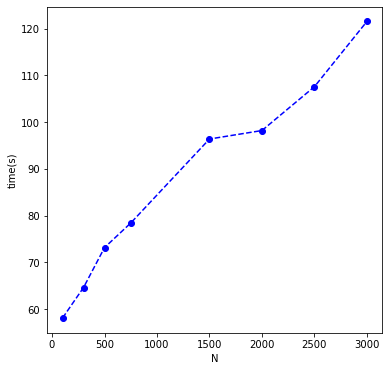

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot([100, 300, 500, 750, 1500, 2000, 2500, 3000], [58.09277153015137, 64.60748648643494, 73.15350866317749, 78.41629195213318, 96.3881585597992, 98.2025363445282, 107.58244895935059, 121.54138159751892], linestyle='--', marker='o', color='b', label='line with marker')
#plt.title('test title')
plt.xlabel('N')
plt.ylabel('time(s)')
plt.show()

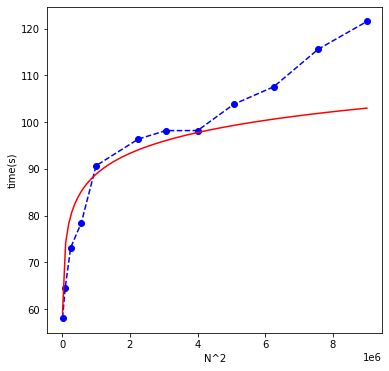

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot([100**2, 300**2, 500**2, 750**2, 1000**2, 1500**2, 1750**2, 2000**2, 2250**2, 2500**2, 2750**2, 3000**2], [58.09277153015137, 64.60748648643494, 73.15350866317749, 78.41629195213318, 90.67683029174805, 96.3881585597992, 98.18414568901062, 98.2025363445282, 103.79779005050659, 107.58244895935059, 115.60685729980469, 121.54138159751892], linestyle='--', marker='o', color='b', label='line with marker')
x = np.linspace(10000, 9000000,100)

y = 6.432* np.log(x)
plt.plot(x, y, 'r')
plt.xlabel('N^2')
plt.ylabel('time(s)')
plt.show()

NameError: name 'plt' is not defined